# ベイズ線形回帰

In [1]:
import os

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

plt.style.use("bmh")
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

assert numpyro.__version__.startswith("0.9.0")

## データセット

このデータセットには、アメリカの50州それぞれの離婚率が、人口、結婚年齢の中央値、南部の州であるかどうか、そして不思議なことにレストランチェーンであるワッフルハウスの数などの予測因子とともに含まれています。

In [18]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")
dset.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


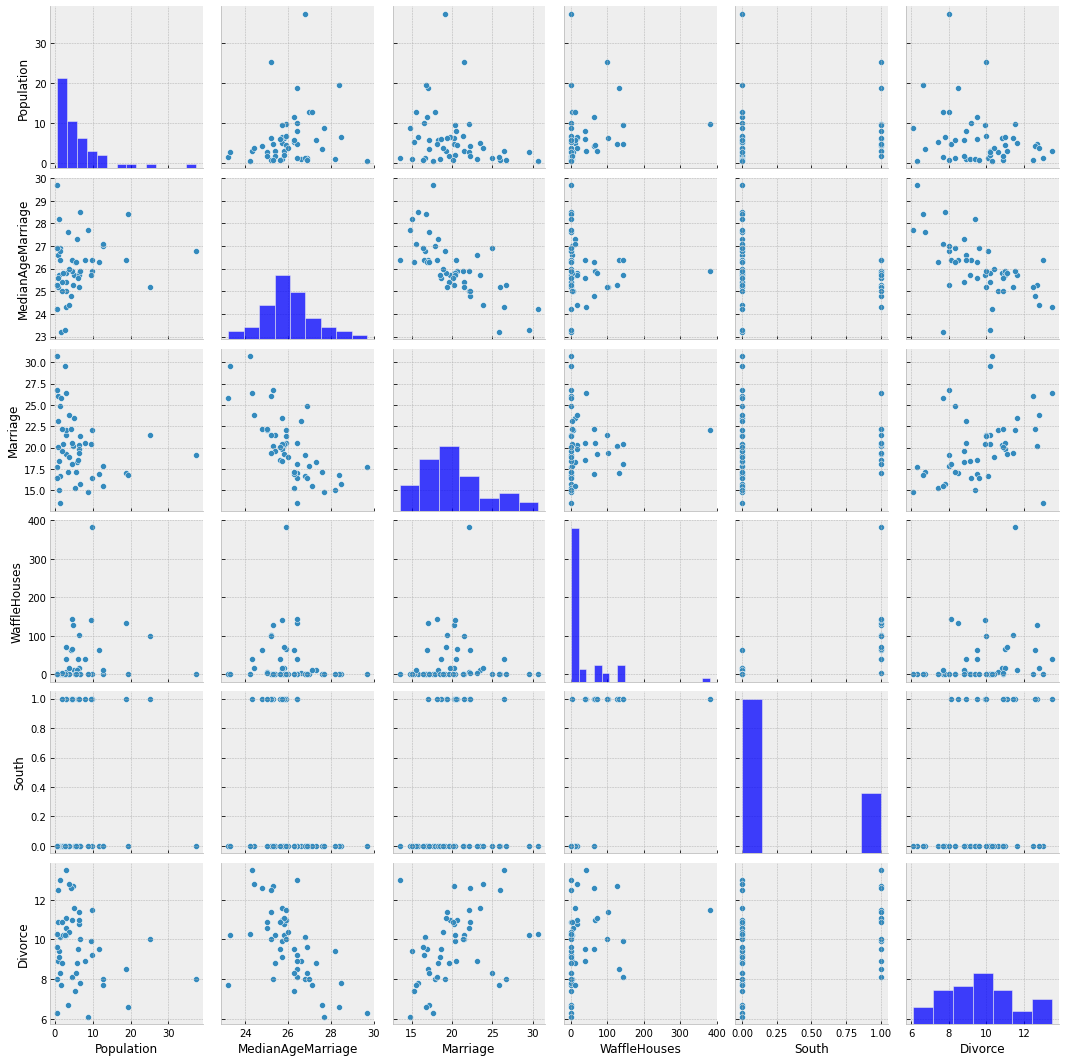

In [19]:
vars = [
    "Population",
    "MedianAgeMarriage",
    "Marriage",
    "WaffleHouses",
    "South",
    "Divorce",
]
sns.pairplot(dset, x_vars=vars, y_vars=vars, palette="husl")
plt.show()

## 回帰モデルの作成

ここでは婚姻率 marriage rateと婚姻年齢の中央値 median age of marriageの一次関数として離婚率を回帰するモデルを考えます。

In [20]:
dset[["MedianAgeMarriage", "Marriage", "Divorce"]].describe()

,MedianAgeMarriage,Marriage,Divorce
count,50.00000,50.000000,50.000000
mean,26.05400,20.114000,9.688000
std,1.24363,3.797905,1.820814
min,23.20000,13.500000,6.100000
25%,25.32500,17.125000,8.300000
50%,25.90000,19.700000,9.750000
75%,26.75000,22.100000,10.900000
max,29.70000,30.700000,13.500000


以上よりそれぞれのデータのスケール感に違いがあるので正規化をしておきます。

In [21]:
standardize = lambda x: (x - x.mean()) / x.std()
dset[["AgeScaled", "MarriageScaled", "DivorceScaled"]] = dset[["MedianAgeMarriage", "Marriage", "Divorce"]].apply(standardize)

In [22]:
def model(marriage=None, age=None, divorce=None):
    a = numpyro.sample("a", dist.Normal(0.0, 0.2))
    M, A = 0.0, 0.0
    if marriage is not None:
        bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
        M = bM * marriage
    if age is not None:
        bA = numpyro.sample("bA", dist.Normal(0.0, 0.5))
        A = bA * age
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mu = a + M + A
    numpyro.sample("obs", dist.Normal(mu, sigma), obs=divorce)

### Model 1: Predictor - Marriage Rate

NumPyroのHamiltonian Monte Carlo（または、NUTS）の実装はポテンシャル・エネルギー（負の対数同時確率）を引数としてとります。したがって、modelではパラメータを与えてポテンシャル・エネルギーを返す関数を構築する必要があります。また、HMC（またはNUTS）のVerlet積分器は、制約のない空間でハミルトニアンダイナミクスを用いてシミュレーションされたサンプル値を返します。そのため、有界の台（関数の値が０とならない点からなる集合が有界）を持つ連続変数は全単射な関数を用いて無制約空間に変換する必要があります（密度が０の場所にいくと止まってしまうので）。また，これらの値をユーザに返す前に，これらのサンプルを有界な台に戻すための変換も必要です．ありがたいことに，これはバックエンドで処理され，以下のメソッドを持つMCMC推論を行うための便利なクラスの中で行われます．

- run(...) : warmupを実行し、ステップサイズと質量行列を適応し、warmupフェーズからのサンプルを使用してサンプリングを行います。
- print_summary(): クオンタイル、有効サンプルサイズ、Gelman-Rubin診断のような診断情報を表示します。
- get_samples(): 事後分布からサンプルを取得します。

以下の点に注意してください。

JAXは関数型PRNGを使用しています。グローバルなランダム状態を維持する他の言語やフレームワークとは異なり、JAXではサンプラーを呼び出すたびに明示的なPRNGKeyが必要になります。誤って同じシードを再利用しないように、初期のランダムシードを後続の処理用に分割します。

In [23]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key_, marriage=dset.MarriageScaled.values, divorce=dset.DivorceScaled.values
)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:04<00:00, 744.33it/s, 3 steps of size 7.86e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.01      0.11      0.01     -0.17      0.19   1511.88      1.00
        bM      0.35      0.13      0.35      0.14      0.57   1694.14      1.00
     sigma      0.95      0.10      0.94      0.78      1.10   1696.30      1.00

Number of divergences: 0


#### 回帰パラメータの事後分布

NUTS を実行している間、プログレスバーには、サンプルごとの受入確率acc. prob、ステップサイズ size、ステップ数steps of sizeのオンライン統計が表示されています。特にウォームアップ時には、ある目標とする受入確率（デフォルトでは0.8）を達成するために、ステップサイズと質量行列（パッと見では見当たらない。運動量の分布を調整している）を調整します。ここではウォームアップ段階でこの目標を達成するためにステップサイズをうまく調整することができました。

ウォームアップの段階では、ステップサイズや質量行列などのハイパーパラメータを適応させ（HMCアルゴリズムはこれらのハイパーパラメータに非常に敏感です）、典型的なセットに到達することを目的としています。モデルの仕様に何か問題がある場合、最初に気づくシグナルは、低い受け入れ確率や非常に高いステップ数でしょう。ウォームアップ・フェーズの最後に得られたサンプルをMCMCチェインのシードとして使用し（2番目のサンプル・プログレス・バーで示される）、そこから目標とする分布から必要な数のサンプルを生成します。

推論の最後に、NumPyroは潜在パラメータの平均値、標準偏差、90%CI値を表示します。予測変数と応答変数を標準化したので、ここで見られるように、切片の平均は0になると予想されることに注意してください。また、モデル内の潜在パラメータに関する他の収束診断の値は、連鎖が目標とする事後分布に収束したことを示します。なお、より複雑なモデルの場合は、複数のチェーンで検証することをお勧めします。最終的にsamples_1は、モデルの各潜在パラメータの事後分布からのサンプルを含むコレクション（ここでは、init_samplesがdictだったので、dict）となります。

回帰の適合性を見るために、回帰パラメータの事後推定値を使って、90%信頼区間（CI）とともに回帰線をプロットしてみましょう。CIの計算には、NumPyroの診断モジュールのhpdi関数を使うことができます。

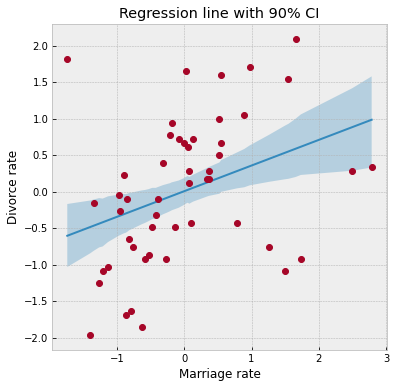

In [25]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, "o")
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax


# Compute empirical posterior distribution over mu
posterior_mu = (
    jnp.expand_dims(samples_1["a"], -1)
    + jnp.expand_dims(samples_1["bM"], -1) * dset.MarriageScaled.values
)

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Regression line with 90% CI"
)
plt.show()

#### 事前予測分布

事前予測分布からサンプリングして、妥当な事前分布が設定できていたことを確認してみましょう。NumPyroは、この目的のために便利な予測分布ユーティリティーを提供します。



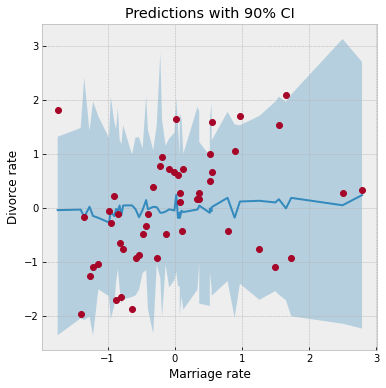

In [26]:
from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, marriage=dset.MarriageScaled.values)[
    "obs"
]
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_prior_pred, hpdi_prior_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI")
plt.show()

#### 事後予測分布

それでは、観測された離婚率に対して我々の予測分布がどのように見えるのか、事後予測分布を見てみましょう。事後予測分布のサンプルを得るためには、潜在的なパラメータを事後分布からのサンプルで置き換えてモデルを実行する必要があります。なお、デフォルトでは、各サンプルに対して事後同時分布から1つの予測値を生成しますが、これは num_samples 引数を使って制御することができます。

In [27]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, marriage=dset.MarriageScaled.values)["obs"]
df = dset.filter(["Location"])
df["Mean Predictions"] = jnp.mean(predictions, axis=0)
df.head()

,Location,Mean Predictions
0,Alabama,0.020609
1,Alaska,0.510827
2,Arizona,0.024643
3,Arkansas,0.611333
4,California,-0.080117


#### Predictive Utility With Effect Handlers

Predictiveの魔法を解き明かすために、エフェクトハンドラとvmap JAXプリミティブを組み合わせて、ベクター化された予測を行うことができる独自のシンプルな予測ユーティリティー関数を実装する方法を見てみましょう。

In [28]:
def predict(rng_key, post_samples, model, *args, **kwargs):
    model = handlers.seed(handlers.condition(model, post_samples), rng_key)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    return model_trace["obs"]["value"]


# vectorize predictions via vmap
predict_fn = vmap(
    lambda rng_key, samples: predict(
        rng_key, samples, model, marriage=dset.MarriageScaled.values
    )
)

predict関数では、condition、seed、traceの効果ハンドラが使用されていることに注意してください。

- seed effect handlers : PRNGKeyの初期シードを持つ確率関数をラップするために使用されます。モデル内のsample文が呼び出されると、分布からサンプリングするために既存のシードを使用しますが、このエフェクトハンドラは、モデル内の将来のsample呼び出しが代わりに新しく分割されたキーを使用するように、既存のキーも分割します。これは、モデル内の各サンプル文にPRNGKeyを明示的に渡さなくても済むようにするためです。
- condition effect handlers : 潜在的なサンプル・サイトを特定の値に条件付けします。ここでは、MCMCによって返される事後分布からの値を条件としています。
- trace effect handlers : モデルを実行し、実行トレースをOrderedDict内に記録します。このトレース・オブジェクトは、対数同時密度などの量を計算するのに便利な実行メタデータを含んでいます。

predict関数は、潜在的なパラメータを（mcmc関数によって生成された）事後結果からのサンプルに置き換えて予測値を生成することにより、モデルを単純に実行することが明らかになっているはずです。予測値をベクトル化するために、vmapというJAXの自動ベクトル化変換を使用していることに注意してください。vmapを使用しなかった場合、各サンプルを処理するネイティブのforループを使用しなければならず、非常に時間がかかることに注意してください。事後分布からの各ドローは、50州すべての予測値を得るために使用できます。これをvmapを使って事後分析のすべてのサンプルに対してベクトル化すると、形が(num_samples, 50)のpredictions_1配列が得られます。次に、これらのサンプルの平均値と90%CIを計算して、事後予測分布をプロットします。平均予測値は、Predictive Utilityクラスから得られた予測値と一致しています。

In [29]:
# Using the same key as we used for Predictive - note that the results are identical.

predictions_1 = predict_fn(random.split(rng_key_, num_samples), samples_1)

mean_pred = jnp.mean(predictions_1, axis=0)
df = dset.filter(["Location"])
df["Mean Predictions"] = mean_pred
df.head()

,Location,Mean Predictions
0,Alabama,0.020609
1,Alaska,0.510827
2,Arizona,0.024643
3,Arkansas,0.611333
4,California,-0.080117


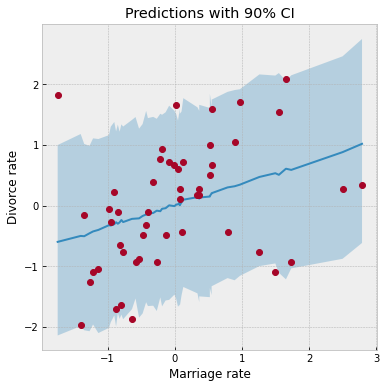

In [30]:
hpdi_pred = hpdi(predictions_1, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI")
plt.show()

#### 事後予測密度

同様に，effect-handlers と vmap を利用して，データセットが与えられたときのこのモデルの対数尤度と，次式で与えられる対数事後予測密度を計算することもできます．

$$
\begin{aligned}
\log \prod_{i=1}^{n} \int p\left(y_{i} \mid \theta\right) p_{\text {post }}(\theta) d \theta \approx \sum_{i=1}^{n} \log \frac{\sum_{s} p\left(\theta^{s}\right)}{S} \\
=\sum_{i=1}^{n}\left(\log \sum_{s} p\left(\theta^{s}\right)-\log (S)\right)
\end{aligned}
$$

ここでは，観測されたデータ点を示し，潜在パラメータに対する事後サンプルを示している．あるモデルの事後予測密度が比較的高い値を示す場合，それは観測されたデータポイントが，与えられたモデルの下でより高い確率を持つことを示している．

In [31]:
def log_likelihood(rng_key, params, model, *args, **kwargs):
    model = handlers.condition(model, params)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    obs_node = model_trace["obs"]
    return obs_node["fn"].log_prob(obs_node["value"])


def log_pred_density(rng_key, params, model, *args, **kwargs):
    n = list(params.values())[0].shape[0]
    log_lk_fn = vmap(
        lambda rng_key, params: log_likelihood(rng_key, params, model, *args, **kwargs)
    )
    log_lk_vals = log_lk_fn(random.split(rng_key, n), params)
    return (logsumexp(log_lk_vals, 0) - jnp.log(n)).sum()

NumPyroはlog_likelihoodユーティリティー関数を提供しており、任意の一般的なモデルについて最初の関数のように対数尤度を計算するために直接使用することができることに注意してください。このチュートリアルでは、このようなユーティリティー関数には何の不思議もなく、NumPyroの効果処理スタックを使って独自の推論ユーティリティーを展開できることを強調したいと思います。

In [32]:
rng_key, rng_key_ = random.split(rng_key)
print(
    "Log posterior predictive density: {}".format(
        log_pred_density(
            rng_key_,
            samples_1,
            model,
            marriage=dset.MarriageScaled.values,
            divorce=dset.DivorceScaled.values,
        )
    )
)

Log posterior predictive density: -66.6878890991211


### Model 2: Predictor - Median Age of Marriage

ここでは、離婚率を結婚年齢の中央値の関数としてモデル化します。計算方法は、モデル1で行ったことをほとんど再現しています。次のことに注意してください。

離婚率は結婚年齢に反比例している。したがって、結婚年齢の中央値が低い州では、離婚率が高くなると考えられます。

モデル2と比較して、より高い対数尤度が得られ、結婚年齢の中央値が離婚率のより良い予測因子であることを示しています。

In [34]:
rng_key, rng_key_ = random.split(rng_key)

mcmc.run(rng_key_, age=dset.AgeScaled.values, divorce=dset.DivorceScaled.values)
mcmc.print_summary()
samples_2 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:06<00:00, 436.07it/s, 3 steps of size 7.32e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.10     -0.01     -0.17      0.17   2028.08      1.00
        bA     -0.57      0.11     -0.57     -0.74     -0.38   1974.47      1.00
     sigma      0.82      0.08      0.82      0.68      0.95   1860.86      1.00

Number of divergences: 0


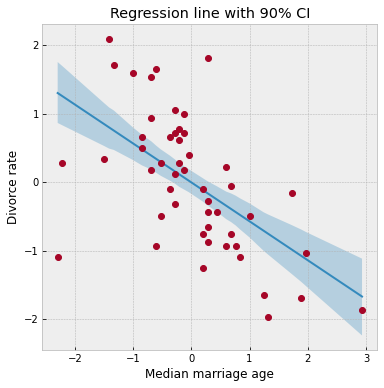

In [36]:
posterior_mu = (
    jnp.expand_dims(samples_2["a"], -1)
    + jnp.expand_dims(samples_2["bA"], -1) * dset.AgeScaled.values
)
mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.AgeScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Median marriage age",
    ylabel="Divorce rate",
    title="Regression line with 90% CI",
)
plt.show()

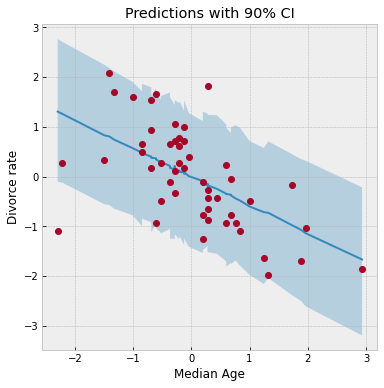

In [38]:
rng_key, rng_key_ = random.split(rng_key)
predictions_2 = Predictive(model, samples_2)(rng_key_, age=dset.AgeScaled.values)["obs"]

mean_pred = jnp.mean(predictions_2, axis=0)
hpdi_pred = hpdi(predictions_2, 0.9)

ax = plot_regression(dset.AgeScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel="Median Age", ylabel="Divorce rate", title="Predictions with 90% CI")
plt.show()

In [39]:
rng_key, rng_key_ = random.split(rng_key)
print(
    "Log posterior predictive density: {}".format(
        log_pred_density(
            rng_key_,
            samples_2,
            model,
            age=dset.AgeScaled.values,
            divorce=dset.DivorceScaled.values,
        )
    )
)

Log posterior predictive density: -59.274169921875


### Model 3: Predictor - Marriage Rate and Median Age of Marriage

最後に、離婚率は婚姻率と婚姻年齢の中央値の両方に依存するというモデルも作成します。このモデルの事後予測密度はモデル2と似ていますが、これは結婚年齢の中央値が既に分かっている場合、離婚率を予測する上で結婚率から得られる限界情報が少ないことを示していると考えられます。

In [40]:
rng_key, rng_key_ = random.split(rng_key)

mcmc.run(
    rng_key_,
    marriage=dset.MarriageScaled.values,
    age=dset.AgeScaled.values,
    divorce=dset.DivorceScaled.values,
)
mcmc.print_summary()
samples_3 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:03<00:00, 775.41it/s, 7 steps of size 5.34e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.10      0.00     -0.17      0.18   2077.82      1.00
        bA     -0.61      0.15     -0.61     -0.88     -0.39   1496.28      1.00
        bM     -0.07      0.15     -0.07     -0.30      0.20   1632.45      1.00
     sigma      0.83      0.08      0.82      0.69      0.95   1910.84      1.00

Number of divergences: 0


In [41]:
rng_key, rng_key_ = random.split(rng_key)
print(
    "Log posterior predictive density: {}".format(
        log_pred_density(
            rng_key_,
            samples_3,
            model,
            marriage=dset.MarriageScaled.values,
            age=dset.AgeScaled.values,
            divorce=dset.DivorceScaled.values,
        )
    )
)

Log posterior predictive density: -59.05039978027344


#### Divorce Rate Residuals by State

上の回帰プロットを見ると、多くの州で観測された離婚率が平均回帰線と大きく異なっていることがわかります。最後のモデル（モデル3）が各州でどのように過小予測または過大予測しているかをより深く掘り下げるために、各州の事後予測と残差（観察された離婚率 - 予測された離婚率）をプロットします。

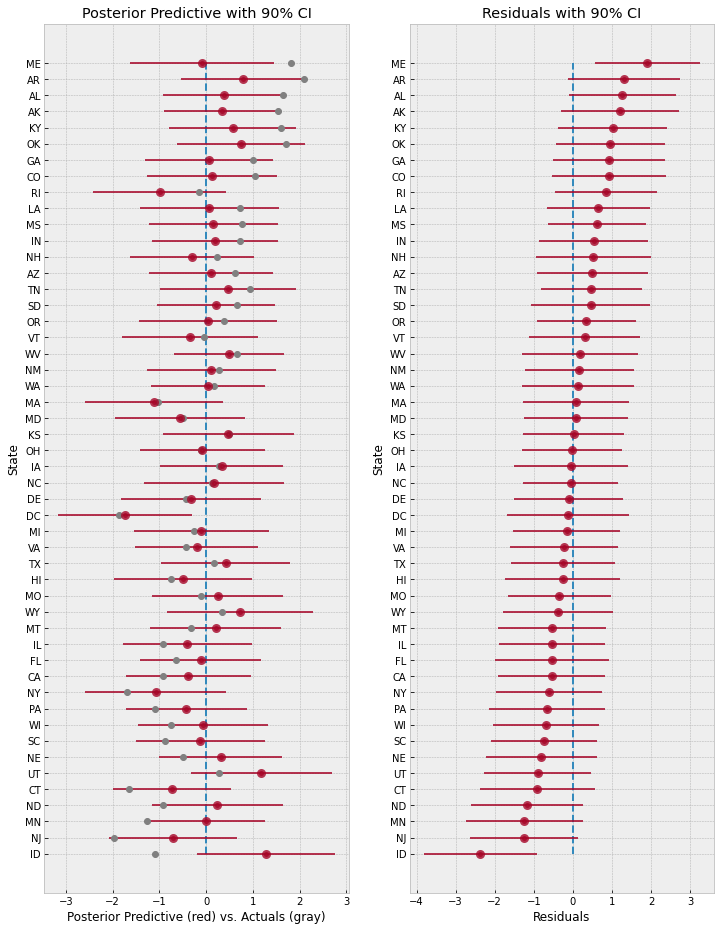

In [42]:
# Predictions for Model 3.
rng_key, rng_key_ = random.split(rng_key)
predictions_3 = Predictive(model, samples_3)(
    rng_key_, marriage=dset.MarriageScaled.values, age=dset.AgeScaled.values
)["obs"]
y = jnp.arange(50)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 16))
pred_mean = jnp.mean(predictions_3, axis=0)
pred_hpdi = hpdi(predictions_3, 0.9)
residuals_3 = dset.DivorceScaled.values - predictions_3
residuals_mean = jnp.mean(residuals_3, axis=0)
residuals_hpdi = hpdi(residuals_3, 0.9)
idx = jnp.argsort(residuals_mean)

# Plot posterior predictive
ax[0].plot(jnp.zeros(50), y, "--")
ax[0].errorbar(
    pred_mean[idx],
    y,
    xerr=pred_hpdi[1, idx] - pred_mean[idx],
    marker="o",
    ms=5,
    mew=4,
    ls="none",
    alpha=0.8,
)
ax[0].plot(dset.DivorceScaled.values[idx], y, marker="o", ls="none", color="gray")
ax[0].set(
    xlabel="Posterior Predictive (red) vs. Actuals (gray)",
    ylabel="State",
    title="Posterior Predictive with 90% CI",
)
ax[0].set_yticks(y)
ax[0].set_yticklabels(dset.Loc.values[idx], fontsize=10)

# Plot residuals
residuals_3 = dset.DivorceScaled.values - predictions_3
residuals_mean = jnp.mean(residuals_3, axis=0)
residuals_hpdi = hpdi(residuals_3, 0.9)
err = residuals_hpdi[1] - residuals_mean

ax[1].plot(jnp.zeros(50), y, "--")
ax[1].errorbar(
    residuals_mean[idx], y, xerr=err[idx], marker="o", ms=5, mew=4, ls="none", alpha=0.8
)
ax[1].set(xlabel="Residuals", ylabel="State", title="Residuals with 90% CI")
ax[1].set_yticks(y)
ax[1].set_yticklabels(dset.Loc.values[idx], fontsize=10)
plt.show()

左の図は、モデル3を用いた各州の平均予測値（90％CI）を示しています。灰色のマーカーは、実際に観測された離婚率を示しています。右側のプロットは、各州の残差を示していますが、どちらも残差でソートされています。

ほとんどの観測データポイントが平均予測値の90％CI内に収まっていることから、全体的にモデルの適合性は良好なようです。しかし、アイダホ州（左下）のような州ではモデルの予測値が大きく上回り、メイン州（右上）のような州では逆に予測値が下回っていることに注目してください。これは、各州の離婚率に影響を与える他の要因が、モデルに含まれていないことを示していると考えられます。他の社会政治的な変数を無視しても、まだモデル化されていない要因の1つは、データセット内の「Divorce SE」によって与えられる測定ノイズです。これについては次のセクションで検討します。

#### Regression Model with Measurement Error

なお、これまでのモデルでは、各データポイントが回帰直線に等しく影響を与えていました。これは正当化されるのでしょうか？我々は、前のモデルを基にして、データセットの離婚SE変数で与えられる測定誤差を組み込みます。測定ノイズを組み込むことは、より高い信頼性を持つ（すなわち、より低い測定ノイズ）オブザベーションが、回帰線により大きな影響を与えることを保証するのに役立ちます。一方で、これは高い測定誤差を持つ外れ値をよりよくモデリングするのにも役立ちます。測定ノイズによる誤差のモデル化の詳細については、[1]の第14章を参照してください。

これを行うために、我々はモデル3を再利用します。唯一の変更点は、最終的な観測値がdivorce_sdで与えられる測定誤差を持つことです（divorce変数自体がmean 0とstd 1に標準化されているので、これは標準化されなければならないことに注意してください）。

In [43]:
def model_se(marriage, age, divorce_sd, divorce=None):
    a = numpyro.sample("a", dist.Normal(0.0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
    M = bM * marriage
    bA = numpyro.sample("bA", dist.Normal(0.0, 0.5))
    A = bA * age
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mu = a + M + A
    divorce_rate = numpyro.sample("divorce_rate", dist.Normal(mu, sigma))
    numpyro.sample("obs", dist.Normal(divorce_rate, divorce_sd), obs=divorce)

In [44]:
# Standardize
dset["DivorceScaledSD"] = dset["Divorce SE"] / jnp.std(dset.Divorce.values)

rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(model_se, target_accept_prob=0.9)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
mcmc.run(
    rng_key_,
    marriage=dset.MarriageScaled.values,
    age=dset.AgeScaled.values,
    divorce_sd=dset.DivorceScaledSD.values,
    divorce=dset.DivorceScaled.values,
)
mcmc.print_summary()
samples_4 = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:04<00:00, 805.68it/s, 15 steps of size 2.32e-01. acc. prob=0.95] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
               a     -0.06      0.10     -0.06     -0.21      0.11   2166.26      1.00
              bA     -0.61      0.16     -0.61     -0.88     -0.36   1561.24      1.00
              bM      0.06      0.16      0.07     -0.20      0.35   1378.38      1.00
 divorce_rate[0]      1.15      0.37      1.14      0.52      1.73   3535.94      1.00
 divorce_rate[1]      0.69      0.55      0.68     -0.29      1.55   3100.26      1.00
 divorce_rate[2]      0.41      0.34      0.40     -0.16      0.94   3843.90      1.00
 divorce_rate[3]      1.41      0.46      1.39      0.69      2.17   2073.59      1.00
 divorce_rate[4]     -0.90      0.13     -0.90     -1.12     -0.70   4310.67      1.00
 divorce_rate[5]      0.65      0.40      0.64     -0.04      1.26   3395.61      1.00
 divorce_rate[6]     -1.35      0.35     -1.34     -1.86     -0.73   3739.57      1.00
 divorce_rate[7]     -0.33      0.47     -

#### Effect of Incorporating Measurement Noise on Residuals

回帰係数の値はモデル3と非常に似ていることに注目してください。しかし、測定ノイズを導入することで、予測分布と観測値をより近づけることができます。これは、先ほどの残差をプロットするとわかります。

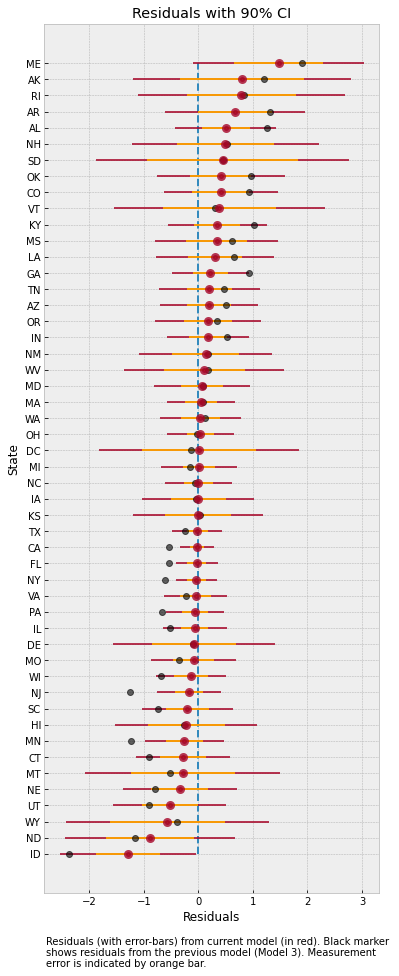

In [45]:
rng_key, rng_key_ = random.split(rng_key)
predictions_4 = Predictive(model_se, samples_4)(
    rng_key_,
    marriage=dset.MarriageScaled.values,
    age=dset.AgeScaled.values,
    divorce_sd=dset.DivorceScaledSD.values,
)["obs"]

sd = dset.DivorceScaledSD.values
residuals_4 = dset.DivorceScaled.values - predictions_4
residuals_mean = jnp.mean(residuals_4, axis=0)
residuals_hpdi = hpdi(residuals_4, 0.9)
err = residuals_hpdi[1] - residuals_mean
idx = jnp.argsort(residuals_mean)
y = jnp.arange(50)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 16))


# Plot Residuals
ax.plot(jnp.zeros(50), y, "--")
ax.errorbar(
    residuals_mean[idx], y, xerr=err[idx], marker="o", ms=5, mew=4, ls="none", alpha=0.8
)

# Plot SD
ax.errorbar(residuals_mean[idx], y, xerr=sd[idx], ls="none", color="orange", alpha=0.9)

# Plot earlier mean residual
ax.plot(
    jnp.mean(dset.DivorceScaled.values - predictions_3, 0)[idx],
    y,
    ls="none",
    marker="o",
    ms=6,
    color="black",
    alpha=0.6,
)

ax.set(xlabel="Residuals", ylabel="State", title="Residuals with 90% CI")
ax.set_yticks(y)
ax.set_yticklabels(dset.Loc.values[idx], fontsize=10)
ax.text(
    -2.8,
    -7,
    "Residuals (with error-bars) from current model (in red). "
    "Black marker \nshows residuals from the previous model (Model 3). "
    "Measurement \nerror is indicated by orange bar.",
);

上の図は，各状態の残差と，内側のエラーバーで示される測定ノイズを示しています．灰色の点は、先ほどのモデル3の平均残差です。測定ノイズをモデル化するための自由度が追加されたことで、残差が縮小していることに注目してください。特に，アイダホ州とメイン州では，測定ノイズをモデルに組み込んだことで，予測値が観測値に非常に近くなっています．

測定ノイズが回帰線の動きにどのように影響するかをよりよく理解するために、測定ノイズに対する残差をプロットしてみましょう。

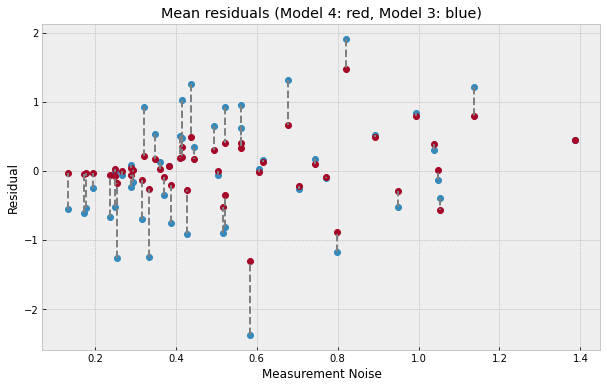

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
x = dset.DivorceScaledSD.values
y1 = jnp.mean(residuals_3, 0)
y2 = jnp.mean(residuals_4, 0)
ax.plot(x, y1, ls="none", marker="o")
ax.plot(x, y2, ls="none", marker="o")
for i, (j, k) in enumerate(zip(y1, y2)):
    ax.plot([x[i], x[i]], [j, k], "--", color="gray")

ax.set(
    xlabel="Measurement Noise",
    ylabel="Residual",
    title="Mean residuals (Model 4: red, Model 3: blue)",
);

上のプロットは、何が起こったかをより詳細に示しています。測定ノイズの少ない観測（プロットの左）では、残差が0に非常に近いところまで縮小し、回帰線自体がよりフィットするように移動しました。一方、測定誤差が大きい状態（プロットの右）では、測定ノイズを取り入れることで、事後分布の質量を観測値に近づけることができ、その結果、残差も縮小します。

## References

McElreath, R. (2016). Statistical Rethinking: A Bayesian Course with Examples in R and Stan CRC Press.

Stan Development Team. Stan User’s Guide

Goodman, N.D., and StuhlMueller, A. (2014). The Design and Implementation of Probabilistic Programming Languages

Pyro Development Team. Poutine: A Guide to Programming with Effect Handlers in Pyro

Hoffman, M.D., Gelman, A. (2011). The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo.

Betancourt, M. (2017). A Conceptual Introduction to Hamiltonian Monte Carlo.

JAX Development Team (2018). Composable transformations of Python+NumPy programs: differentiate, vectorize, JIT to GPU/TPU, and more

Gelman, A., Hwang, J., and Vehtari A. Understanding predictive information criteria for Bayesian models